In [1]:
import os
import sys
from IPython.display import Markdown, display, Image
import numpy as np
import pandas as pd
import random
import math
import dvc.api
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from app_logger import App_Logger
import plots
from sklearn import preprocessing
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

sns.set()




In [2]:
from helper import Helper
from cleanTrainData import CleanTrainData
from cleanStoreDf import CleanStoreDf

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
helper = Helper()

In [6]:
train_df = helper.read_csv("../data/train.csv")
store_df = helper.read_csv("../data/store.csv")
test_df = helper.read_csv("../data/test.csv")

file read as csv
file read as csv
file read as csv


In [7]:

def to_category( df):

    df["Open"] = df["Open"].astype("category")
    df["DayOfWeek"] = df["DayOfWeek"].astype("category")
    df["Promo"] = df["Promo"].astype("category")
    df["StateHoliday"] = df["StateHoliday"].astype("category")
    df["SchoolHoliday"] = df["SchoolHoliday"].astype("category")
    df['StateHoliday'] = df['StateHoliday'].astype("str").astype("category")
    return df

   

In [8]:
class PreprocessRossmanData:
    
    def __init__(self):
        pass
    
        
    def handle_outliers(self, df, col, method="lower_upper"):
        
        df = df.copy()
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)

        lower_bound = q1 - ((1.5) * (q3 - q1))
        upper_bound = q3 + ((1.5) * (q3 - q1))

        if method == "mean":
            df[col] = np.where(df[col] < lower_bound,   df[col].mean(), df[col])
            df[col] = np.where(df[col] > upper_bound, df[col].mean(), df[col])

        elif  method == "mode":
            df[col] = np.where(df[col] < lower_bound,   df[col].mode()[0], df[col])
            df[col] = np.where(df[col] > upper_bound, df[col].mode()[0], df[col])
        else:
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

        return df
    
    def transform_date(self, df):
        
        df['Date'] = pd.to_datetime(df['Date'])
        df['Year'] = pd.DatetimeIndex(df['Date']).year
        df['Month'] = pd.DatetimeIndex(df['Date']).month
        df['Day'] = pd.DatetimeIndex(df['Date']).day
        
        df['Year'] = df['Year'].astype("int")
        df['Month'] = df['Month'].astype("category")
        df['Day'] = df['Day'].astype("category")
        df['DayInMonth'] = df['Day'].apply(lambda x: self.to_month_category(x))
        df['DayInMonth'] =  df['DayInMonth'].astype("category")
        return df
    
    def to_month_category(self, value):
        try:
            if (value >= 1 and int(value) < 10):
                return "BegMonth"

            elif (value >= 10 and value < 20):
                return "MidMonth"
            else:
                return "EndMonth"
        except:
            pass
    
    def add_weekday_col(self, df):
      
        df["Weekends"] = df["DayOfWeek"].apply(lambda x: 1 if x > 5 else 0)
        df["Weekends"] = df["Weekends"].astype("category")
        return df
    
    def encode_train_data(self, df):
        
        StateHolidayEncoder = preprocessing.LabelEncoder()
        DayInMonthEncoder = preprocessing.LabelEncoder()
        
        df['StateHoliday'] = StateHolidayEncoder.fit_transform(df['StateHoliday'])
        df['DayInMonth'] = DayInMonthEncoder.fit_transform(df['DayInMonth'])
        return df
        
    def encode_store_data(self, df):
        StoreTypeEncoder = preprocessing.LabelEncoder()
        AssortmentEncoder = preprocessing.LabelEncoder()
        PromoIntervalEncoder = preprocessing.LabelEncoder()

        
#         PromoInterval
        df['StoreType'] = StoreTypeEncoder.fit_transform(df['StoreType'])
        df['Assortment'] = AssortmentEncoder.fit_transform(df['Assortment'])
        df['PromoInterval'] = PromoIntervalEncoder.fit_transform(df['PromoInterval'])

        return df
    
    def merge_encoded(self, train_enc, store_enc):
        return pd.merge(train_enc, store_enc, on="Store")
    
    def process(self, train_df, store_df, is_test_data=False):
        
#         enc_train = self.encode_train_data(train_df)
#         enc_store = self.encode_store_data(store_df)
        
#         enc_train = enc_train.drop(columns=["Date"], axis=1)
        
        train_df = self.transform_date(train_df)
        train_df = self.add_weekday_col(train_df)
        
        if (not is_test_data):
            train_df = self.handle_outliers(train_df, "Sales")
            train_df = self.handle_outliers(train_df, "Customers")

        store_df = self.handle_outliers(store_df, "CompetitionDistance")
        
        
        merged = self.merge_encoded(train_df, store_df)
#         sclaed = helper.scaler(merged, merged.columns.to_list(), mode="standard")
        
        return merged
    
        
        
    
        
        
    

In [9]:

clean_train_df = CleanTrainData().get_cleaned(train_df)
clean_store_df = CleanStoreDf().get_cleaned(store_df)
cleaned_rossman_data = PreprocessRossmanData().process(clean_train_df, clean_store_df)

In [11]:


def loss_function(actual, pred):
    mae = mean_absolute_error(actual, pred)
    return mae

class RossmanModelPipeline:
    
    def __init__(self, cleaned_rossman_data, model_name):  
       
        self.X_train, self.X_test, self.y_train, self.y_test = self.prepare_data(cleaned_rossman_data)
        self.model_name = model_name
    
    def prepare_data(self, cleaned_rossman_data):
        feat_cols = ['DayOfWeek','Promo','StateHoliday','SchoolHoliday','Year', 'Open',
                     'Month','Day','Weekends','StoreType','Assortment','CompetitionDistance',
                     'CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2',
                     'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval', "DayInMonth"]
        
        X = cleaned_rossman_data[feat_cols]
        y = cleaned_rossman_data["Sales"]
        return train_test_split(X, y, test_size=0.2)
    
    def Preproccessor(self):  
        cols = self.X_train.columns
        numric_cols = ["CompetitionDistance", "Promo2SinceWeek", "Year"]
        categorical_cols = self.X_train.copy(deep=True).drop(columns=numric_cols, index=1, inplace=False).columns.to_list()
        
        numeric_transformer = Pipeline(steps=[('scaler', StandardScaler()),
                                              ('imputer', SimpleImputer(strategy='mean'))])
        categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                                  ('encoder', OrdinalEncoder())])
        
        preprocessor = ColumnTransformer(
            transformers=[('numric', numeric_transformer, numric_cols),
                          ('category', categorical_transformer, categorical_cols)])
        return preprocessor
    
    def train(self, regressor=RandomForestRegressor(n_jobs=-1, max_depth=15, n_estimators=15)):
        
        preprocessor = self.Preproccessor()
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', regressor)])
        
#         mlflow.set_experiment('Rossman-' + self.model_name)
#         mlflow.sklearn.autolog()
#         with mlflow.start_run(run_name="Baseline"):
        model = pipeline.fit(self.X_train, self.y_train)
                
        return pipeline, model
    
    
    def test(self, model):
        
        predictions = model.predict(self.X_test)
        score_2 = r2_score(self.y_test, predictions)
        loss = loss_function(predictions, self.y_test)
        print(f" R2 score of model is: {score_2:.3f}")

        print(f"step Mean abs error of model is: {loss:.3f}")
        
        result_df = self.X_test.copy()
        result_df["Prediction Sales"] = predictions
        result_df["Actual Sales"] = self.y_test
        result_agg = result_df.groupby("Day").agg({"Prediction Sales": "mean", "Actual Sales":"mean"})
        
        return score_2, loss, result_agg
 
    
    def pred_graph(self, res_dataframe):
        
        fig = plt.figure(figsize=(18, 5))
        sns.lineplot(x = res_dataframe.index, y = res_dataframe["Actual Sales"], label='Actual')
        sns.lineplot(x = res_dataframe.index, y = res_dataframe["Prediction Sales"], label='Prediction')
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel(xlabel="Day", fontsize=16)
        plt.ylabel(ylabel="Sales", fontsize=16)
        plt.show()
        
        return fig
    
    def get_feature_importance(self, model):
        if (type(model.steps[1][1]) == type(LinearRegression())):
            model = model.steps[1][1]
           
            p_df = pd.DataFrame()
            p_df['features'] = self.X_train.columns.to_list()
            p_df['coff_importance'] = abs(model.coef_)
            
            return p_df
        
        importance = model.steps[1][1].feature_importances_
        f_df = pd.DataFrame(columns=["features", "importance"])
        f_df["features"] = self.X_train.columns.to_list()
        f_df["importance"] = importance
        return f_df
        
        
        

        
        
        
        
        

### Sales Prediction Using RandomForset Regressor

In [14]:

regressor = RandomForestRegressor(n_jobs=-1, max_depth=15, n_estimators=15)

rossPipeLine = RossmanModelPipeline(cleaned_rossman_data, "RandomForset-2")
pipeline, model = rossPipeLine.train(regressor=regressor)


 R2 score of model is: 0.858
step Mean abs error of model is: 898.629


,Prediction Sales,Actual Sales
Day,,
1,4331.697295,4554.850603
2,6480.947291,6810.959179
3,5704.123135,5803.862399
4,6535.768722,6710.744644
5,6144.950785,6203.949544
6,5829.918570,5834.500880
7,5902.360512,5981.939004
8,5567.751395,5586.052192
9,5191.160118,5129.003963


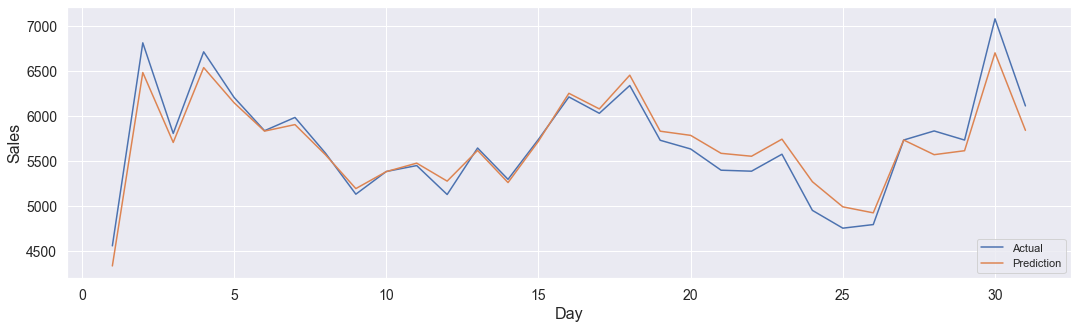

In [15]:
score, loss, res_df = rossPipeLine.test(model)
display(res_df)
fig = rossPipeLine.pred_graph(res_df)

In [22]:
import time


timestamp = time.time()
helper.write_model(f"regressor_model-{timestamp}", model)

In [23]:
def model_infer(model, test_df):
    test_df  = to_category(test_df)
    megred_df_test = PreprocessRossmanData().process(test_df, clean_store_df, is_test_data=True)

    feat_cols = ['DayOfWeek','Promo','StateHoliday','SchoolHoliday','Year', 'Open',
                         'Month','Day','Weekends','StoreType','Assortment','CompetitionDistance',
                         'CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2',
                         'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval', "DayInMonth"]


    pred = model.predict(megred_df_test[feat_cols].copy())

    pred_df = test_df.copy()

    pred_df["Sales-Prediction"] = pred
    return pred_df
    

#### Model inference using RandomForest model

In [25]:
rf_model = helper.read_model(f"regressor_model-{timestamp}")
display(model_infer(rf_model, test_df))


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,DayInMonth,Weekends,Sales-Prediction
0,1,1,4,2015-09-17,1.0,1,0,0,2015,9,17,MidMonth,0,5549.025932
1,2,3,4,2015-09-17,1.0,1,0,0,2015,9,17,MidMonth,0,5549.025932
2,3,7,4,2015-09-17,1.0,1,0,0,2015,9,17,MidMonth,0,6090.545775
3,4,8,4,2015-09-17,1.0,1,0,0,2015,9,17,MidMonth,0,7823.916151
4,5,9,4,2015-09-17,1.0,1,0,0,2015,9,17,MidMonth,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,2015,8,1,BegMonth,1,6914.414154
41084,41085,1112,6,2015-08-01,1.0,0,0,0,2015,8,1,BegMonth,1,6914.414154
41085,41086,1113,6,2015-08-01,1.0,0,0,0,2015,8,1,BegMonth,1,7742.463876
41086,41087,1114,6,2015-08-01,1.0,0,0,0,2015,8,1,BegMonth,1,0.000000


#### Feature Importance using RandomForest

In [26]:
random_feat_imp = rossPipeLine.get_feature_importance(model).sort_values(by=["importance"], ascending=False)
display(random_feat_imp)

,features,importance
7,Day,0.602599
0,DayOfWeek,0.092270
4,Year,0.089538
14,Promo2,0.036745
13,CompetitionOpenSinceYear,0.035418
3,SchoolHoliday,0.027204
1,Promo,0.023125
11,CompetitionDistance,0.021350
16,Promo2SinceYear,0.014259
8,Weekends,0.013576


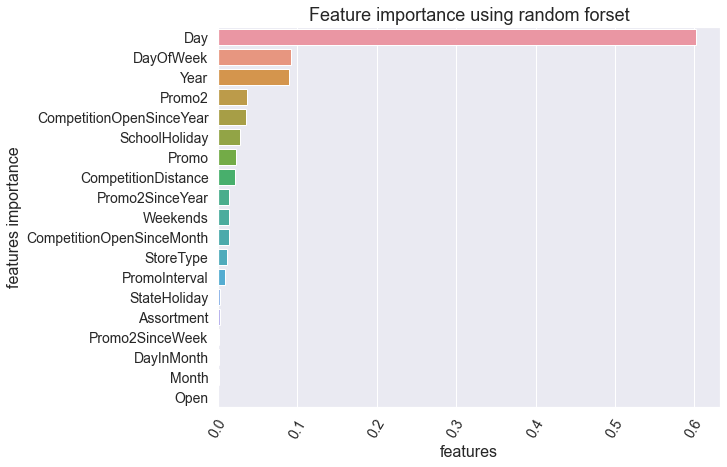

In [27]:
plots.plot_bar(random_feat_imp,  "importance", "features","Feature importance using random forset", "features",
               "features importance")

### Sales Prediction Using Linear Regressor

In [28]:
rossPipeLine_2 = RossmanModelPipeline(cleaned_rossman_data, "LinearRegression")
pipeline_2, model_2 = rossPipeLine_2.train(regressor= LinearRegression())


 R2 score of model is: 0.609
step Mean abs error of model is: 1669.839


,Prediction Sales,Actual Sales
Day,,
1,4328.136910,4556.758156
2,6363.386188,6838.559311
3,5594.839046,5664.459079
4,6592.411424,6750.121972
5,6246.991569,6182.204399
6,6058.877813,5830.747070
7,6070.297798,5935.437472
8,5807.971597,5587.914445
9,5423.721453,5249.293853


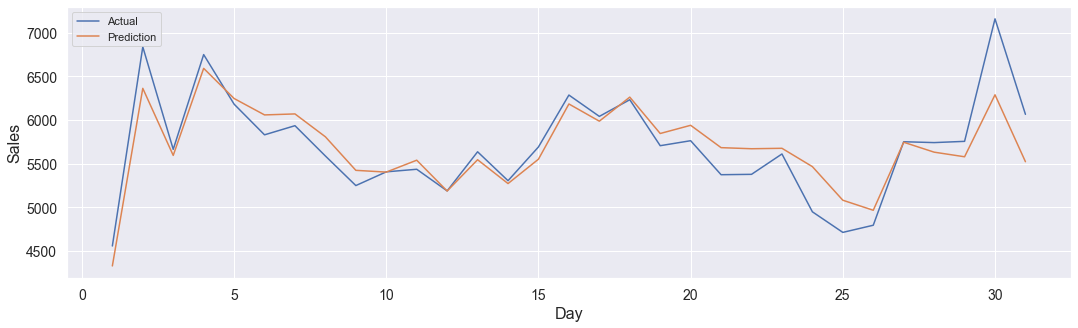

In [29]:
score_2, loss_2, res_df_2 = rossPipeLine_2.test(model_2)
display(res_df_2)
fig = rossPipeLine_2.pred_graph(res_df_2)

#### Feature Importance using Linear Regressor

In [30]:
lr_feat_imp = rossPipeLine_2.get_feature_importance(model_2).sort_values(by=["coff_importance"], ascending=False)
display(lr_feat_imp)

,features,coff_importance
7,Day,5775.188372
4,Year,2093.092368
10,Assortment,638.746990
5,Open,423.650900
12,CompetitionOpenSinceMonth,308.253177
1,Promo,252.554910
3,SchoolHoliday,203.946063
6,Month,147.108366
0,DayOfWeek,141.215596
2,StateHoliday,125.222834


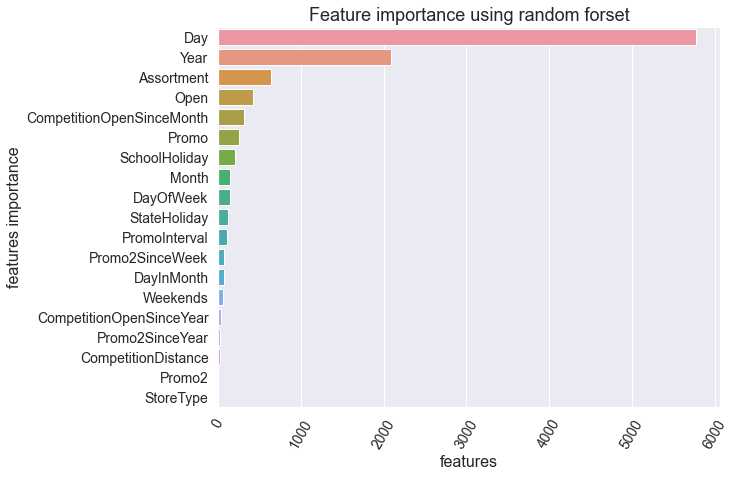

In [31]:
plots.plot_bar(lr_feat_imp,  "coff_importance", "features","Feature importance using random forset", "features",
               "features importance")

In [33]:

timestamp2 = time.time()

helper.write_model(f"lr_model-{timestamp2}", model_2)

#### Model inference using LR model on test data


In [34]:
lr_model = helper.read_model(f"lr_model-{timestamp2}")
display(model_infer(lr_model, test_df))

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,DayInMonth,Weekends,Sales-Prediction
0,1,1,4,2015-09-17,1.0,1,0,0,2015,9,17,MidMonth,0,8120.192754
1,2,3,4,2015-09-17,1.0,1,0,0,2015,9,17,MidMonth,0,8322.268924
2,3,7,4,2015-09-17,1.0,1,0,0,2015,9,17,MidMonth,0,8524.345095
3,4,8,4,2015-09-17,1.0,1,0,0,2015,9,17,MidMonth,0,8726.421266
4,5,9,4,2015-09-17,1.0,1,0,0,2015,9,17,MidMonth,0,271.341246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,2015,8,1,BegMonth,1,8323.564317
41084,41085,1112,6,2015-08-01,1.0,0,0,0,2015,8,1,BegMonth,1,8525.640488
41085,41086,1113,6,2015-08-01,1.0,0,0,0,2015,8,1,BegMonth,1,8727.716659
41086,41087,1114,6,2015-08-01,1.0,0,0,0,2015,8,1,BegMonth,1,272.636639


In [43]:
def get_data(tag, path='data/data.csv', repo='https://github.com/daniEL2371/pharmaceutical-sales-prediction'):
        rev = tag
        data_url = dvc.api.get_url(path=path, repo=repo, rev=rev)
        df = pd.read_csv(data_url)
        app_logger.info(f"Read data from {path}, version {tag}")

        return df